In [24]:

import numpy as np
import scipy as sp
import pandas as pd
import scipy.special
import climpy.utils.wrf_chem_utils as wrf_chem
import matplotlib.pyplot as plt

__author__ = 'Sergey Osipov <Serega.Osipov@gmail.com>'

## This example answers following question:

### Given the total mass of aerosols, what coefficient should I use to get PM2.5 and PM10?

Atmospheric science often deals with the quantities such as PM10, which are particles up to 10 um in diameters.
To get the modes contribution to specific PM size, we need to integrate size distribution.

The integration can be done numerically, but it can be slow. For the log-normal pdfs there is analytical solution expressed through the error function.
This approach is much faster and allows simple use of the single coefficient to convert mass to PM.

The example was designed for the MADE/SORGAM implementation in WRF-Chem (chem_opt=105), which uses 3 log normal modes, to describe aerosols.
See for details https://patarnott.com/pdf/SizeDistributions.pdf, equations 24-27

In [25]:
# Normally, to get the size distribution parameters of WRF-Chem sim you should use this:
# sg_list, dg_list, moment0_list, moment3_list = aqaba.get_wrf_sd_params(nc)
# But to keep example simple and give an idea on the range of value, I've tabulated typical values below

sg_list = [1.7, 2.0, 2.5]
dg_list = [2.15e-8, 2.65e-8, 4.29e-7]
#moment0_list = [50e8, 12e8, 1.5e8]
# Last value 1.5e5 was adjusted from 1.5e8 to force 3rd mode contribute to volume/mass more or less equally
moment0_list = [50e8, 12e8, 1.5e5]
# We don't need next raw in this example, but you will need it to derive dg from WRF-Chem simulation
moment3_list = [177e-15, 1865e-15, 530e-12]

In [26]:
print('Setup the parameters of the three log normal modes')
data = np.array([sg_list, dg_list, moment0_list, moment3_list]).transpose()
pd.DataFrame(data, columns=["sg", "dg", 'N_0 (# of particles)', 'V_0 (volume)'])


Setup the parameters of the three log normal modes


,sg,dg,N_0 (# of particles),V_0 (volume)
0,1.7,2.150000e-08,5.000000e+09,1.770000e-13
1,2.0,2.650000e-08,1.200000e+09,1.865000e-12
2,2.5,4.290000e-07,1.500000e+05,5.300000e-10


Strictly speaking analytical distribution spans values from $-\infty$ to $+\infty$.
1. Pick the grid for diameter/radius
2. Sample distribution

In [27]:
dp = np.logspace(-9, -4, 100)
radii = dp / 2

# sample the distributions
dNdlogp_list = wrf_chem.sample_WRF_MADE_size_distributions(dp, sg_list, dg_list, moment3_list, moment0_list)

# compute 3rd moment/volume
dVdlogp_list = []
for dNdlogp in dNdlogp_list:
     dVdlogp = dNdlogp * 4 / 3 * np.pi * (radii*10**-6) ** 3
     dVdlogp_list.append(dVdlogp)

In [35]:
def plot_size_distribution_pm_diags(radii, dVdlogp_list, V_factors, d_min, d_max):
    fig = plt.figure(constrained_layout=True)#, figsize=(get_full_screen_page_width_inches()/2, 9.85416667), dpi=MY_DPI)
    plt.grid()
    ind = np.logical_and(radii >= d_min/2, radii <= d_max/2)

    for dVdlogp, V_factor in zip(dVdlogp_list, V_factors):
        plt.fill_between(radii[ind]*10**6, dVdlogp[ind], alpha=0.3, label='{:.3f}'.format(V_factor))#, color='orange')
        plt.plot(radii*10**6, dVdlogp, '-', markersize=1)#, color='orange')
    plt.legend()
    plt.title('Modes overlap with the PM {:.2f}-{:.2f} $\mu m$'.format(d_min*10**6, d_max*10**6))

    plt.xscale('log')
    # plt.yscale('log')
    # plt.xlim([1 * 10 ** -2, 5 * 10 ** 1])
    plt.xlabel('Radius, ($\mu $m)')
    plt.ylabel('dV/dlogr, ($\mu m^3/cm^3$)')

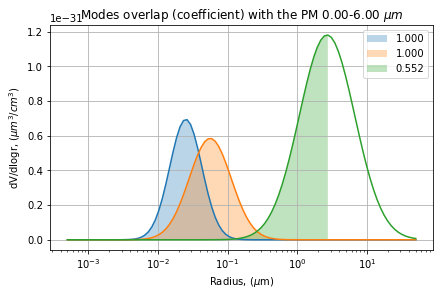

In [38]:
# define the range of sizes, this is PM10 essentially
d_min = 10**-20  # m
d_max = 10 * 10 ** -6  # m

N_factors, V_factors = wrf_chem.compute_MADE_bounded_distribution_factors(d_min, d_max, sg_list, dg_list, moment3_list, moment0_list)
plot_size_distribution_pm_diags(radii, dVdlogp_list, V_factors, d_min, d_max)

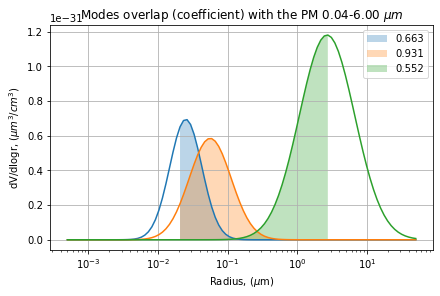

In [41]:
# And one more, this is PM10
d_min = 0.4 * 10**-7  # m
d_max = 6 * 10 ** -6  # m

N_factors, V_factors = wrf_chem.compute_MADE_bounded_distribution_factors(d_min, d_max, sg_list, dg_list, moment3_list, moment0_list)
plot_size_distribution_pm_diags(radii, dVdlogp_list, V_factors, d_min, d_max)

# d_min = 4 * 10**-6  # m
# d_max = 100 * 10**-6  # um
# d_min = 3 * 10**-8  # m

# d_min = 1 * 10**-7  # m
# d_max = 10 * 10**-6  # um

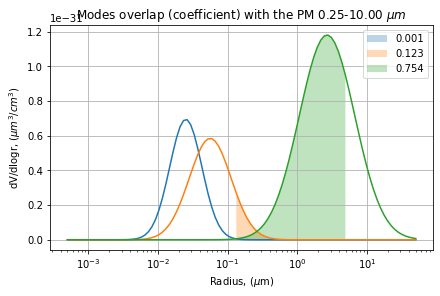

In [42]:
# AQABA measurements case, 250 nm - 10 microns.
d_min = 0.25 * 10 ** -6  # m
d_max = 10 * 10 ** -6  # um

N_factors, V_factors = wrf_chem.compute_MADE_bounded_distribution_factors(d_min, d_max, sg_list, dg_list, moment3_list, moment0_list)
plot_size_distribution_pm_diags(radii, dVdlogp_list, V_factors, d_min, d_max)
